# Import the necessary libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

### Load the data into Pandas dataframe

In [59]:
df = pd.read_csv('C:\\Users\\HP\\Desktop\\Text_Classification_Kaggle\\spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Drop the columns that are not required for the neural network.

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


Understand the distribution better.

Text(0.5, 1.0, 'Number of ham and spam messages')

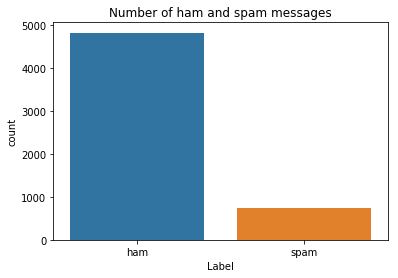

In [9]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

* Create input and output vectors.
* Process the labels.

In [10]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [11]:
print(Y)
Y.shape

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


(5572, 1)

Split into training and test data.

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [13]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [14]:
'''
Tokenizer:    allows to vectorize a text corpus, by turning each text into either a sequence of integers   
              (each integer being the index of a token in a dictionary) or into a vector where
              the coefficient for each token could be binary, based on word count, based on tf-idf...

'''

'\nTokenizer:    allows to vectorize a text corpus, by turning each text into either a sequence of integers   \n              (each integer being the index of a token in a dictionary) or into a vector where\n              the coefficient for each token could be binary, based on word count, based on tf-idf...\n\n'

### RNN
Define the RNN structure.

In [53]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 50, input_length = max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(256, name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

Call the function and compile the model.

In [54]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])    # pqarams 91648

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               8448      
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

Fit on the training data.

In [55]:
model.fit(sequences_matrix, Y_train, batch_size = 128, epochs = 10,
          validation_split = 0.2, callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 9s 2ms/step - loss: 0.3337 - acc: 0.8709 - val_loss: 0.1550 - val_acc: 0.9420
Epoch 2/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.1049 - acc: 0.9747 - val_loss: 0.0578 - val_acc: 0.9842
Epoch 3/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0521 - acc: 0.9847 - val_loss: 0.0562 - val_acc: 0.9789
Epoch 4/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0340 - acc: 0.9900 - val_loss: 0.0444 - val_acc: 0.9852
Epoch 5/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0256 - acc: 0.9923 - val_loss: 0.0436 - val_acc: 0.9863
Epoch 6/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0178 - acc: 0.9952 - val_loss: 0.0455 - val_acc: 0.9873


The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [56]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [57]:
accr = model.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - 1s 880us/step


In [58]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.062
  Accuracy: 0.986


In [16]:
'''
Embeddings:     Embeddings(input_dim, output_dim, input_length)   ( Word Embedding Layer)
                Embeddingd is relatively low dimentional space comes from translated 
                high dimentional vectors.
                Word embedding is the collective name for a set of language modeling 
                and feature learning texhniques in NLP. words or phrases from the vocabulary
                are mapped to vectors of real numbers.

LSTM:           (LSTM) networks are a type of RNN capable of learning order dependence in sequence prediction problems.
         
Dense layer:     A dense layer is a classic fully connected neural network layer : each input node is connected to each output node.
                 The dense layer is fully connected layer, so all the neurons in a layer are connected to those in a next layer.
                 
Activation:      Their main purpose is to convert a input signal of a node in a A-NN to an output signal.  

Dropouts:        Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex   
                 co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. 
                 The term "dropout" refers to dropping out units (both hidden and visible) in a neural network.

'''

'\nEmbeddings:     Embeddings(input_dim, output_dim, input_length)   ( Word Embedding Layer)\n                Embeddingd is relatively low dimentional space comes from translated \n                high dimentional vectors.\n                Word embedding is the collective name for a set of language modeling \n                and feature learning texhniques in NLP. words or phrases from the vocabulary\n                are mapped to vectors of real numbers.\n\nLSTM:           (LSTM) networks are a type of RNN capable of learning order dependence in sequence prediction problems.\n         \nDense layer:     A dense layer is a classic fully connected neural network layer : each input node is connected to each output node.\n                 The dense layer is fully connected layer, so all the neurons in a layer are connected to those in a next layer.\n                 \nActivation:      Their main purpose is to convert a input signal of a node in a A-NN to an output signal.  \n\nDropouts:  